In [1]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [2]:
import os

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
%matplotlib inline

In [4]:
import torch
import torch.nn            as nn
import torch.nn.functional as F

In [5]:
import numpy as np
import yaml
import math

In [6]:
from peaknet.datasets.SFX           import SFXMulticlassDataset
from peaknet.modeling.reg_bifpn_net import PeakNet
from peaknet.utils import print_layers, set_seed, split_dataset
from peaknet.plugins  import PsanaImg, apply_mask
from peaknet.trans import PadBottomRight
from peaknet.configurator import Configurator
from peaknet.trans import RandomShift,  \
                          RandomRotate, \
                          RandomPatch

In [7]:
from cupyx.scipy import ndimage
import cupy as cp

In [8]:
path_yaml = "experiments/yaml/opt_cxi.00.yaml"
with open(path_yaml, 'r') as fh:
    config_dict = yaml.safe_load(fh)
CONFIG = Configurator.from_dict(config_dict)

In [9]:
# ...Checkpoint
drc_chkpt           = CONFIG.CHKPT.DIRECTORY
path_pretrain_chkpt = CONFIG.CHKPT.PRETRAIN
fl_chkpt_prefix     = CONFIG.CHKPT.FILENAME_PREFIX
path_chkpt_prev     = CONFIG.CHKPT.PATH_CHKPT_PREV
chkpt_saving_period = CONFIG.CHKPT.CHKPT_SAVING_PERIOD
epoch_unstable_end  = CONFIG.CHKPT.EPOCH_UNSTABLE_END

# ...Dataset
path_dataset  = CONFIG.DATASET.PATH
cxi_key       = CONFIG.DATASET.CXI_KEY
size_sample   = CONFIG.DATASET.SAMPLE_SIZE
frac_train    = CONFIG.DATASET.FRAC_TRAIN
frac_validate = CONFIG.DATASET.FRAC_VALIDATE
size_batch    = CONFIG.DATASET.BATCH_SIZE
num_workers   = CONFIG.DATASET.NUM_WORKERS

# ...Model
bifpn_num_blocks    = CONFIG.MODEL.BIFPN.NUM_BLOCKS
bifpn_num_features  = CONFIG.MODEL.BIFPN.NUM_FEATURES
bifpn_num_levels    = CONFIG.MODEL.BIFPN.NUM_LEVELS
bifpn_base_level    = CONFIG.MODEL.BIFPN.NUM_LEVELS
seghead_num_classes = CONFIG.MODEL.SEG_HEAD.NUM_CLASSES
freezes_backbone    = CONFIG.MODEL.FREEZES_BACKBONE
uses_random_weights = CONFIG.MODEL.USES_RANDOM_WEIGHTS

# ...Loss
focal_alpha = CONFIG.LOSS.FOCAL.ALPHA
focal_gamma = CONFIG.LOSS.FOCAL.GAMMA

# ...Optimizer
lr           = float(CONFIG.OPTIM.LR)
weight_decay = float(CONFIG.OPTIM.WEIGHT_DECAY)
grad_clip    = float(CONFIG.OPTIM.GRAD_CLIP)

# ...Scheduler
## patience            = CONFIG.LR_SCHEDULER.PATIENCE
warmup_epochs       = CONFIG.LR_SCHEDULER.WARMUP_EPOCHS
total_epochs        = CONFIG.LR_SCHEDULER.TOTAL_EPOCHS
min_lr              = float(CONFIG.LR_SCHEDULER.MIN_LR)
uses_prev_scheduler = CONFIG.LR_SCHEDULER.USES_PREV


# ...DDP
ddp_backend            = CONFIG.DDP.BACKEND
uses_unique_world_seed = CONFIG.DDP.USES_UNIQUE_WORLD_SEED

# ...Logging
drc_log       = CONFIG.LOGGING.DIRECTORY
fl_log_prefix = CONFIG.LOGGING.FILENAME_PREFIX

# ...Misc
uses_mixed_precision = CONFIG.MISC.USES_MIXED_PRECISION
max_epochs           = CONFIG.MISC.MAX_EPOCHS
num_gpus             = CONFIG.MISC.NUM_GPUS

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
peaknet_config = PeakNet.get_default_config()
peaknet_config.BIFPN.NUM_BLOCKS     = bifpn_num_blocks
peaknet_config.BIFPN.NUM_FEATURES   = bifpn_num_features
peaknet_config.BIFPN.NUM_LEVELS     = bifpn_num_levels
peaknet_config.BIFPN.BASE_LEVEL     = bifpn_base_level
peaknet_config.SEG_HEAD.NUM_CLASSES = seghead_num_classes
model = PeakNet(peaknet_config).to(device)
print(f"{sum(p.numel() for p in model.parameters())/1e6} M pamameters.")

26.508754 M pamameters.


In [12]:
print_layers(model, max_depth = 2)

PeakNet
- (backbone): ImageEncoder
  - (encoder): ResNet50
- (backbone_to_bifpn): ModuleList
  - (0): Conv2d
  - (1): Conv2d
  - (2): Conv2d
  - (3): Conv2d
- (bifpn): BiFPN
  - (blocks): Sequential
- (seg_lateral_layers): ModuleList
  - (0): SegLateralLayer
  - (1): SegLateralLayer
  - (2): SegLateralLayer
  - (3): SegLateralLayer
- (head_segmask): Conv2d


In [13]:
# path_chkpt = "pretrained_chkpts/transfered_weights.resnet50.chkpt"
# chkpt = torch.load(path_chkpt)

# model.backbone.encoder.load_state_dict(chkpt, strict = False)

In [14]:
fl_chkpt = "opt_cxi.00.2023_1108_2307_12.epoch_96.chkpt"

chkpt = torch.load(os.path.join("experiments/chkpts", fl_chkpt))

model.load_state_dict(chkpt['model_state_dict'])

<All keys matched successfully>

In [15]:
# path_traced_model = "traced_model.pt"
# if path_traced_model is not None:
#     model = torch.jit.load(path_traced_model, map_location = device)

In [158]:
from psalgos.pypsalgos import PyAlgos

alg = PyAlgos()
# alg.set_peak_selection_pars(npix_min=2, npix_max=30, amax_thr=300, atot_thr=600, son_min=10)
alg.set_peak_selection_pars(npix_min=2, npix_max=50, amax_thr=50, atot_thr=100, son_min=7)
# hdr = '\nSeg  Row  Col  Npix    Amptot'
# fmt = '%3d %4d %4d  %4d  %8.1f'
# for nevent,evt in enumerate(ds.events()):
#     if nevent>=2 :
#         break
#     nda = det.calib(evt)
#     if nda is None:
#         continue
#     peaks = alg.peak_finder_v4r2(nda, thr_low=5, thr_high=21, rank=4, r0=5, dr=0.05)
#     print(hdr)
#     for peak in peaks :
#         seg,row,col,npix,amax,atot = peak[0:6]
#         print(fmt % (seg, row, col, npix, atot))

In [17]:
# exp           = 'mfx13016'
# run           = 34
# img_load_mode = 'calib'
# access_mode   = 'idx'
# detector_name = 'Rayonix'

# psana_img = PsanaImg(exp, run, access_mode, detector_name)
# mask_bad_pixel = psana_img.create_bad_pixel_mask()

In [18]:
# exp           = 'mfxx49820'
# run           = 107
# img_load_mode = 'calib'
# access_mode   = 'idx'
# detector_name = 'MfxEndstation.0:Epix10ka2M.0'

# psana_img = PsanaImg(exp, run, access_mode, detector_name)
# mask_bad_pixel = psana_img.create_bad_pixel_mask()

In [19]:
exp           = 'cxic00318'
run           = 123
img_load_mode = 'calib'
access_mode   = 'idx'
detector_name = 'CxiDs1.0:Jungfrau.0'

psana_img = PsanaImg(exp, run, access_mode, detector_name)
mask_bad_pixel = psana_img.create_bad_pixel_mask()

In [150]:
# mfx13016
event = 1909

# mfxx49820
event = 12928
event = 810
event = 14219
event = 11852
event = 29129
event = 14364
event = 1030
event = 9088
event = 7507
event = 11852

# cxic00318
event = 5111
event = 230145
event = 32010
event = 3424
event = 187902
event = 94840
event = 67567
event = 69028
event = 48757
# event = 166407

img = psana_img.get(event, None, 'calib')
# img = psana_img.get(event, None, 'raw') & 0b0011_1111_1111_1111
# img = img.astype(np.float32)
img = apply_mask(img, mask_bad_pixel, mask_value = 0)

H, W = img.shape[-2:]
base_size = 2**5
dummy_offset = 0
H_pad, W_pad = math.ceil(H / base_size + dummy_offset) * base_size, math.ceil(W / base_size + dummy_offset) * base_size

img = torch.tensor(img).type(dtype=torch.float)[:,None,].to(device)
img = (img - img.mean()) / img.std()

# Predict peaks...
model.eval()

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()
with torch.no_grad():
    fmap = model(img)
mask_predicted = fmap.softmax(dim = 1)
# mask_predicted = fmap
end_event.record()
torch.cuda.synchronize()
print(f"Elapsed: {start_event.elapsed_time(end_event)} ms")

Elapsed: 90.15090942382812 ms


In [151]:
img.shape

torch.Size([8, 1, 512, 1024])

In [152]:
B, C, H, W = mask_predicted.shape
mask_predicted = mask_predicted.argmax(dim = 1, keepdims = True)
mask_predicted = F.one_hot(mask_predicted.reshape(B, -1), num_classes = C).permute(0, 2, 1).reshape(B, -1, H, W)
label_predicted = mask_predicted[:,1]
label_predicted = label_predicted.to(torch.int)

# Locate peaks with coordinates...
# [unique] multipanel
structure = cp.zeros((3, 3, 3), dtype=bool)
# Define structure in 2D image at the middle layer
structure[1] = cp.array([[1,1,1],
                         [1,1,1],
                         [1,1,1]])
peak_predicted, num_peak_predicted = ndimage.label(cp.asarray(label_predicted), structure)
peak_pos_predicted_list = ndimage.center_of_mass(cp.asarray(label_predicted), peak_predicted, cp.asarray(range(1, num_peak_predicted+1)))

label_predicted = label_predicted.cpu().detach().numpy()
label_predicted_asmb = psana_img.assemble(multipanel = label_predicted)

(0.0, 1.0, dtype('float32'))

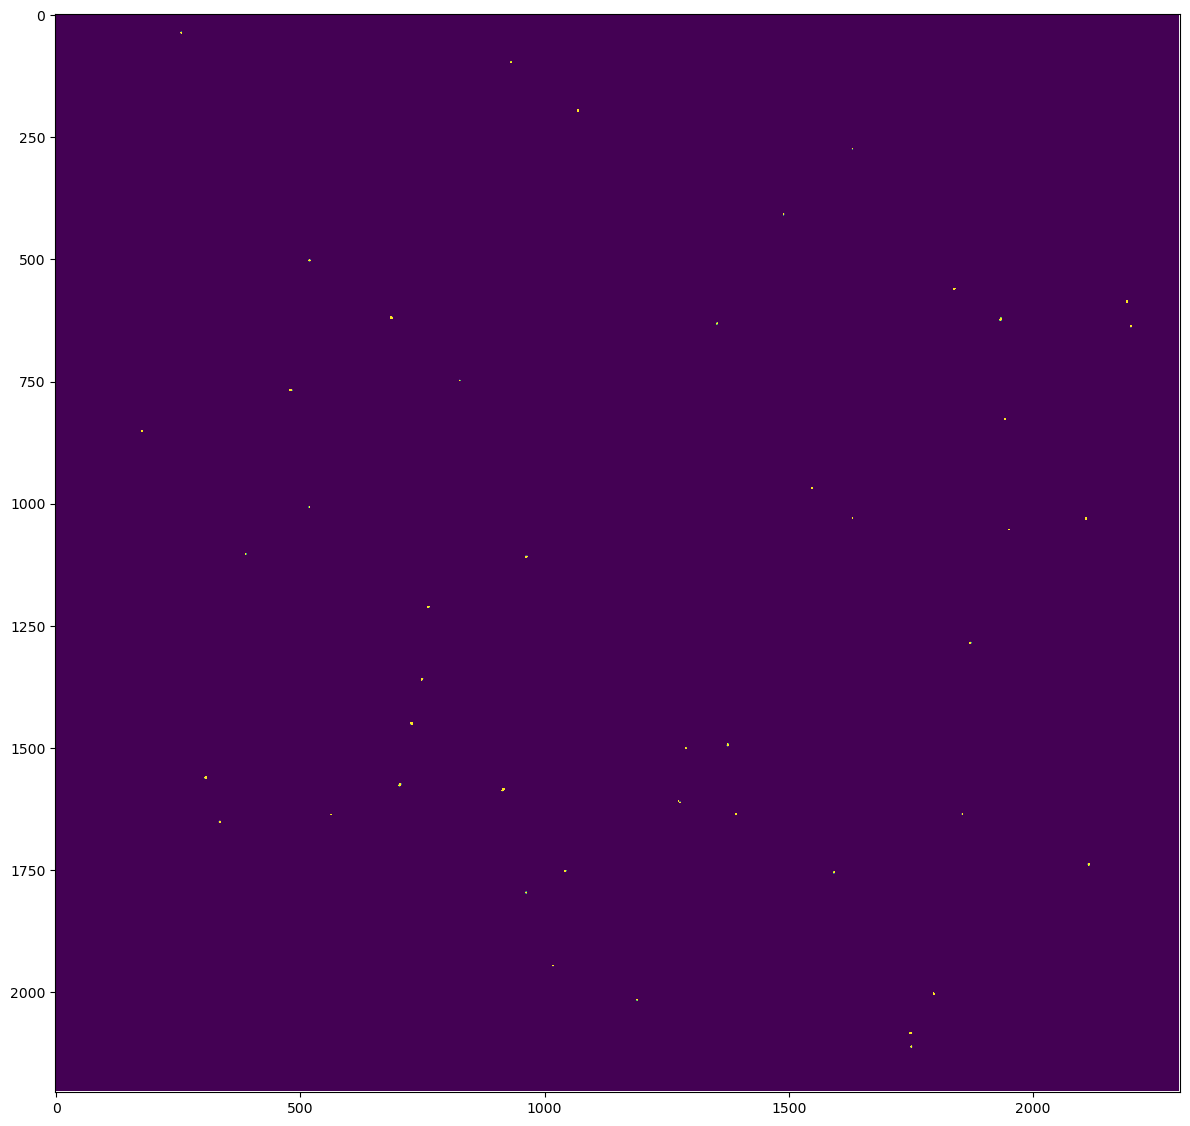

In [153]:
offset = 4
b_offset = 2
size_y, size_x = label_predicted_asmb.shape[-2:]
y_bmin, x_bmin = 0, 0
y_bmax, x_bmax = size_y, size_x

scale = 1

# [[[ Visual ]]]
# Set up the visual
ncols = 1
nrows = 1
fig   = plt.figure(figsize = (16*scale,14*scale))
gspec = fig.add_gridspec( nrows, ncols,
                          width_ratios  = [1],
                          height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1),  ]

# Plot image
data = label_predicted_asmb[:]
vmin = np.mean(data) - 0 * data.std()
vmax = np.mean(data) + 6 * data.std()
im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
# im = ax_list[0].imshow(data, vmin = 0, vmax = 0.2)
# im.set_clim(vmin, vmax)
ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])
ax_list[0].invert_yaxis()
data.min(), data.max(), data.dtype

In [154]:
indexes_x = psana_img.detector.indexes_x(event)
indexes_y = psana_img.detector.indexes_y(event)

assemble_peak_pos_predicted_list = []
for s, y, x in peak_pos_predicted_list:
    y_asmb = indexes_x[int(s), int(y), int(x)]
    x_asmb = indexes_y[int(s), int(y), int(x)]

    assemble_peak_pos_predicted_list.append([y_asmb, x_asmb])

assemble_peak_pos_predicted_list = np.asarray(assemble_peak_pos_predicted_list)

In [159]:
img = psana_img.get(event, None, 'calib')
# img = psana_img.get(event, None, 'raw') & 0b0011_1111_1111_1111
# img = img.astype(np.float32)

img = apply_mask(img, mask_bad_pixel, mask_value = 0)
img = psana_img.assemble(img)
peaks = alg.peak_finder_v3r3(img, rank=3, r0=3, dr=2)

In [160]:
size_y, size_x = img.shape[-2:]

(2203.0, 0.0)

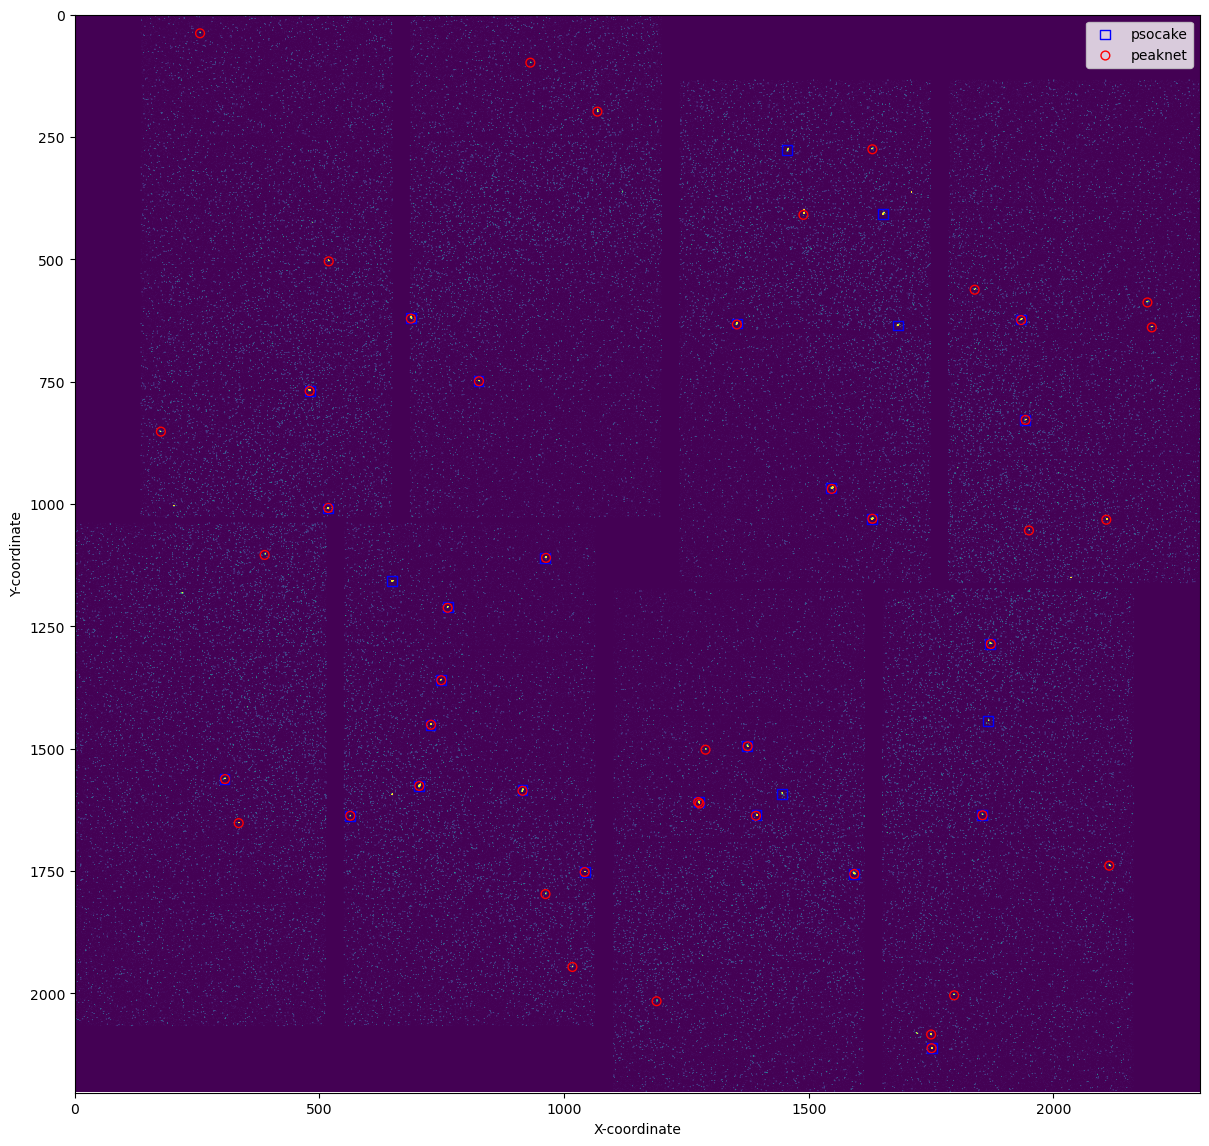

In [173]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

# Assume coords_a and coords_b are your two lists of coordinates
coords_a = peaks[:, 1:1+2]
# coords_b = np.array([ (y, x) for y, x in assemble_peak_pos_predicted_list ])
coords_b = assemble_peak_pos_predicted_list

# Compute a cost matrix.
cost_matrix = cdist(coords_a, coords_b)

# Use linear_sum_assignment to find the optimal assignment.
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Filter assignments based on some threshold distance.
# threshold_distance = np.inf
threshold_distance = 5
close_pairs = [(i, j) for i, j in zip(row_ind, col_ind) if cost_matrix[i, j] <= threshold_distance]

# Create a new figure
scale = 1
ncols = 1
nrows = 1
fig   = plt.figure(figsize = (16*scale,14*scale))
gspec = fig.add_gridspec( nrows, ncols,
                          width_ratios  = [1],
                          height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1), ]

# Plot image
ax = ax_list[0]
data = img
vmin = np.median(data) - 0 * data.std()
vmax = np.median(data) + 0.1 * data.std()
im = ax.imshow(data, vmin = vmin, vmax = vmax)
# im = ax.imshow(data, vmin = 0, vmax = 1)


# Plot all points from both sets.
ax.scatter(coords_a[:, 1], coords_a[:, 0], s = 50, edgecolors='blue', facecolors='none', linewidths=1.0, label='psocake', marker = 's')
ax.scatter(coords_b[:, 1], coords_b[:, 0], s = 40, edgecolors='red', facecolors='none', linewidths=1, label='peaknet')

# Draw lines between matched points.
# for i, j in close_pairs:
#     ax.plot([coords_a[i, 1], coords_b[j, 1]], [coords_a[i, 0], coords_b[j, 0]], '-x', color='black', linewidth = 1, alpha = 1)
    # ax.scatter(coords_a[:, 1], coords_a[:, 0], s = 50, edgecolors='blue', facecolors='none', linewidths=1.0, label='psocake', marker = 's')

# Add labels and legend.
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.legend()
# ax.grid(True)
# ax.invert_yaxis()
ax.set_xlim(0, size_x)
ax.set_ylim(size_y, 0)

In [171]:
data.mean(), data.max(), data.std()

(0.13715741, 107197.67, 80.38927)